In [15]:
#Source : 파이썬을 활용한 금융공학 레시피 by 김용환

import bs4
from urllib.request import urlopen
import re
import matplotlib.pyplot as plt
%matplotlib inline

def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source, 'lxml')
    
    #X-path : //*[@id="cTB11"]/tbody/tr[7]/td
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '')
    tmp = tmp.replace('\n', '')
    tmp = tmp.replace('\t', '')
    tmp = re.split('/', tmp)
    
    #number of stocks
    outstanding = tmp[0].replace(',', '')
    outstanding = outstanding.replace('주', '')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    
    #floating ratio
    floating = tmp[1].replace(' ', '')
    floating = floating.replace('%', '')
    floating = float(floating)
    
    name = soup.find(id = 'pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

k10_component = ['005930','000660', '035420', '051910', '207940', '068270', '005380', '035720', '006400','051900']
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    stock_info(stock_cd)


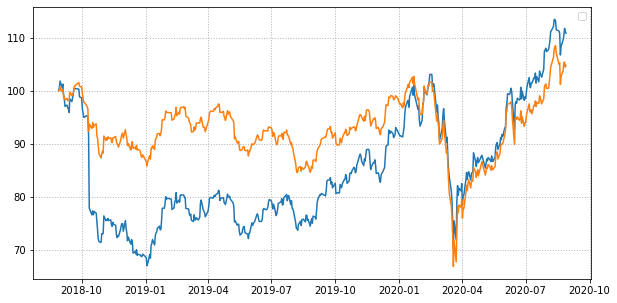

In [16]:
import datetime as dt
import pandas as pd

def date_format_html(d):
    d = str(d).replace('-', '.')
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_stock_naver_date(stock_cd, start_date='', end_date = '', page_n=1, last_page=0):
    if start_date:
        start_date=date_format_html(start_date)
    else: 
        start_date = dt.date.today()
    if end_date : 
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = bs4.BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('span', class_ = 'tah p10 gray03') 
    prices = source.find_all('td', class_='num') 
    
    for n in range(len(dates)):
        
        if len(dates) >0 :
            this_date = dates[n].text
            this_date = date_format_html(this_date)
        
        if this_date <= end_date and this_date >= start_date:
            this_close = prices[n*6].text
            this_close = this_close.replace(',', '')
            this_close = float(this_close)
            
            historical_prices[this_date] = this_close
        
        elif this_date < start_date :
            return historical_prices
    
    if last_page ==0:
        last_page = source.find_all('table')[1].find('td',class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    if page_n < last_page:
        page_n = page_n +1
        historical_stock_naver_date(stock_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices

k10_historical_prices = dict()

for stock_cd in k10_component:
    historical_prices = dict()
    start_date = '2018-8-29'
    end_date = '2020-8-29'
    historical_stock_naver_date(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices
    
k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True)

k10_historical_price = k10_historical_price.fillna(method='ffill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='bfill')

tmp = {
    'Outstanding' : k10_outstanding,
    'Floating' : k10_floating,
    'Price' : k10_historical_price.iloc[0],
    'Name' : k10_name
}
k10_info = pd.DataFrame(tmp)

k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Floating'] * k10_info['Price'] *0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01

k10_historical_mc = k10_historical_price *k10_info['Outstanding'] * k10_info['Floating'] * 0.01 #daily market cap
k10_historical_mc.sum(axis=1) #sum of daily market cap

k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.sort_index(inplace=True)

k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'][0] *100


def date_format_html(d):
    d = str(d).replace('-', '.') 
    yyyy=int(d.split('.')[0])
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date = dt.date(yyyy,mm,dd)
    return this_date

def historical_index_naver_date(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    index_cd = index_cd
    page_n = page_n
    
    
    if start_date: 
        start_date=date_format_html(start_date)
    else: 
        start_date = dt.date.today() 
    if end_date : 
        end_date=date_format_html(end_date)
    else:
            end_date=dt.date.today()
    
    naver_index = 'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n) #일별시세-프레임소스보기
    source = urlopen(naver_index).read()
    source = bs4.BeautifulSoup(source, 'lxml') 
    
    dates=source.find_all('td',class_='date') #<td class ="date">
    prices=source.find_all('td', class_='number_1') #<td class = "number_1">
    
    for n in range(len(dates)):
        if dates[n].text.split('.')[0].isdigit():
            this_date = dates[n].text
            this_date = date_format_html(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                this_close=prices[n*4].text
                this_close=this_close.replace(',', '') 
                this_close=float(this_close)
                this_close
    
                historical_prices_date[this_date] = this_close
            
            elif this_date < start_date:
                return historical_prices_date
    
    if last_page ==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page=int(last_page)
    
    if page_n < last_page:
        page_n = page_n +1
        historical_index_naver_date(index_cd, start_date, end_date, page_n, last_page)
    
    return historical_prices_date

historical_prices_date=dict()
kospi200=historical_index_naver_date('KPI200', '2018-8-29', '2020-8-29')
k200 = pd.DataFrame({'K200':kospi200})

plt.figure(figsize=(10,5))
plt.plot(k10['K10']/k10['K10'][0] * 100)
plt.plot(k200['K200'] / k200['K200'][0] *100)
plt.legend(loc='best')
plt.grid(True, color='0.7', linestyle = ':', linewidth=1)

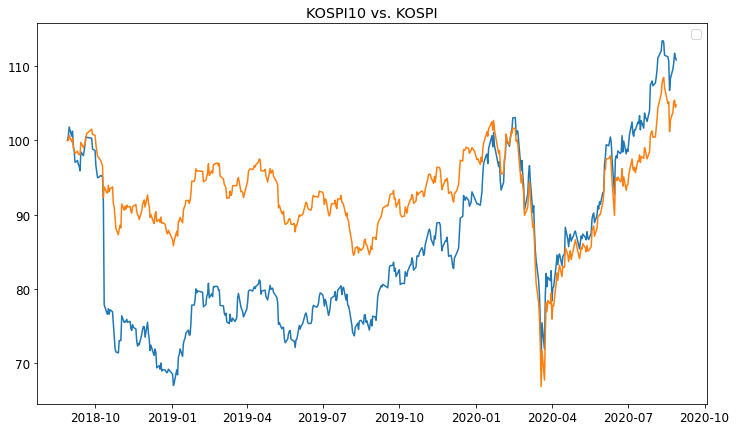

In [23]:
plt.figure(figsize=(12,7))
plt.plot(k10['K10']/k10['K10'][0] * 100, label = 'KOSPI10')
plt.plot(k200['K200'] / k200['K200'][0] *100, label = 'KOSPI')
plt.title('KOSPI10 vs. KOSPI')
plt.legend(loc='best')